## Patches Extractor

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import sys
import os
import time

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities_NOMXNET import *

/Users/kuiqian/Github/MouseBrainAtlas_dev/src//utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/local/Cellar/python@2/2.7.16/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/kuiqian/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/kuiqian/MouseBrainAtlas_dev/mousebrainatlas_virtualenv/lib/python2.

Setting environment for an unknown machine. Global root paths must be set as env variables.
{'MD589': 0.46}
Loaded data from saved metadata_cache for MD589


No vtk
No mcubes
Folder for stack MD585 not found, skipping.
Folder for stack MD590 not found, skipping.
Folder for stack MD591 not found, skipping.
Folder for stack MD592 not found, skipping.
Folder for stack MD593 not found, skipping.
Folder for stack MD594 not found, skipping.
Folder for stack MD595 not found, skipping.
Folder for stack MD598 not found, skipping.
Folder for stack MD599 not found, skipping.
Folder for stack MD602 not found, skipping.
Folder for stack MD603 not found, skipping.
Folder for stack MD635 not found, skipping.
Folder for stack MD653 not found, skipping.
Folder for stack MD652 not found, skipping.
Folder for stack MD642 not found, skipping.
Folder for stack MD657 not found, skipping.
Folder for stack MD658 not found, skipping.
Folder for stack MD661 not found, skipping.
Folder for stack MD662 not found, skipping.
Folder for stack CHATM2 not found, skipping.
Folder for stack CHATM3 not found, skipping.
Folder for stack UCSD001 not found, skipping.
/Users/kuiq

### Variables definition

In [14]:
win_id = 1
stack = 'MD589'

paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

# 1: {'patch_size': 224, 'spacing': 56}
patch_loc_root = ROOT_DIR+'/CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/'
images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/'
raw_images_root = ROOT_DIR+'/CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'

patch_fn_list = ! ls $patch_loc_root
image_fn_list = ! ls $images_root
raw_image_fn_list = ! ls $raw_images_root

filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [3]:
windowing_settings

{1: {'patch_size': 224, 'spacing': 56},
 2: {'comment': 'larger margin', 'patch_size': 224, 'spacing': 56},
 3: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 32},
 4: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 128},
 5: {'comment': 'smaller spacing', 'patch_size': 224, 'spacing': 64},
 6: {'comment': 'twice as large patch', 'patch_size': 448, 'spacing': 64},
 7: {'comment': 'specify size/spacing in terms of microns rather than pixels',
  'patch_size_um': 103.04,
  'spacing_um': 30},
 8: {'comment': 'larger patch', 'patch_size_um': 206.08, 'spacing_um': 30},
 9: {'comment': 'larger patch', 'patch_size_um': 412.16, 'spacing_um': 30},
 10: {'comment': 'larger patch', 'patch_size_um': 824.32, 'spacing_um': 30},
 11: {'comment': 'larger patch', 'patch_size_um': 51.52, 'spacing_um': 30},
 12: {'comment': 'larger patch', 'patch_size_um': 25.76, 'spacing_um': 30}}

### Download essential files

In [4]:
def setup_download_from_s3( rel_fp, recursive=True ):
    s3_fp = 's3://mousebrainatlas-data/'+rel_fp
    local_fp = os.environ['ROOT_DIR']+rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return 
    
    if recursive:
        ! aws s3 cp --recursive $s3_fp $local_fp
    else:
        ! aws s3 cp $s3_fp $local_fp

In [5]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_metadata_cache.json', recursive=False)

ALREADY DOWNLOADED FILE


In [6]:
setup_download_from_s3('CSHL_patch_locations/'+stack+'/'+stack+'_prep2_gray_win1/')

ALREADY DOWNLOADED FILE


In [7]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/')

ALREADY DOWNLOADED FILE


In [31]:
setup_download_from_s3( 'CSHL_data_processed/MD585/MD585_sorted_filenames.txt', recursive=False ) # Change

download: s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_sorted_filenames.txt to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_sorted_filenames.txt


In [ ]:
#setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless/')

In [8]:
local_fp = os.environ['ROOT_DIR']+'CSHL_labelings_v3/MD589/MD589_annotation_contours_05312018031718.hdf'
!aws s3 cp s3://mousebrainatlas-data/annotations_realigned/MD589_annotation_contours_05312018031718_prep2_corr1.hdf $local_fp

download: s3://mousebrainatlas-data/annotations_realigned/MD589_annotation_contours_05312018031718_prep2_corr1.hdf to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD589/MD589_annotation_contours_05312018031718.hdf


In [22]:
stack = 'MD585'

In [59]:
local_fp = os.environ['ROOT_DIR']+'CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf'
! aws s3 cp s3://mousebrainatlas-data/annotations_realigned/MD585_annotation_contours_05312018041032_prep2_corr2.hdf $local_fp

download: s3://mousebrainatlas-data/annotations_realigned/MD585_annotation_contours_05312018041032_prep2_corr2.hdf to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf


In [24]:
setup_download_from_s3('CSHL_data_processed/'+stack+'/'+stack+'_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif',recursive=False)

download: s3://mousebrainatlas-data/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif to ../../../../BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif


### Identify patches based on human annotation
--script identify_patch_class_based_on_labeling_v3_human_annotations.py

In [5]:
fp, latest_timestamp = DataManager.get_annotation_filepath(stack, by_human=True, suffix='contours', \
            timestamp='latest', return_timestamp=True, annotation_rootdir=ANNOTATION_ROOTDIR, download_s3=False)
grid_index_class_lookup_fp = \
    DataManager.get_annotation_to_grid_indices_lookup_filepath(stack=stack, win_id=win_id, 
                                                               by_human=True, timestamp=latest_timestamp)
if not os.path.exists(grid_index_class_lookup_fp):
    ! python identify_patch_class_based_on_labeling_v3_human_annotations.py MD589 1
else:
    print('ALREADY IDENTIFY PATCHES')

grid_index_class_lookup = load_hdf_v2(grid_index_class_lookup_fp)

latest timestamp:  05312018031718
ENABLE_UPLOAD_S3 is not set, default to False.
ENABLE_DOWNLOAD_S3 is not set, default to False.
Setting environment for an unknown machine. Global root paths must be set as env variables.
{'MD589': 0.46}
No vtk
No mcubes
Folder for stack MD585 not found, skipping.
Loaded data from saved metadata_cache for MD589
Folder for stack MD590 not found, skipping.
Folder for stack MD591 not found, skipping.
Folder for stack MD592 not found, skipping.
Folder for stack MD593 not found, skipping.
Folder for stack MD594 not found, skipping.
Folder for stack MD595 not found, skipping.
Folder for stack MD598 not found, skipping.
Folder for stack MD599 not found, skipping.
Folder for stack MD602 not found, skipping.
Folder for stack MD603 not found, skipping.
Folder for stack MD635 not found, skipping.
Folder for stack MD653 not found, skipping.
Folder for stack MD652 not found, skipping.
Folder for stack MD642 not found, skipping.
Folder for stack MD657 not found, ski

Computing grid indices lookup for section 122...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N21-2015.07.30-17.23.23_MD589_3_0063_prep2_thumbnail_mask.png
Computing grid indices lookup for section 123...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC21-2015.07.30-22.40.00_MD589_3_0063_prep2_thumbnail_mask.png
Computing grid indices lookup for section 124...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N22-2015.07.30-17.27.26_MD589_1_0064_prep2_thumbnail_mask.png
Computing grid indices lookup for section 125...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC22-2015.07.30-22.44.25_MD589_1_0064_prep2_thumbnail_mask.png
Computing grid indices lookup for section 126...
Trying to load /Use

Computing grid indices lookup for section 158...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_prep2_thumbnail_mask.png
Computing grid indices lookup for section 159...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_prep2_thumbnail_mask.png
Computing grid indices lookup for section 160...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_prep2_thumbnail_mask.png
Computing grid indices lookup for section 161...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_prep2_thumbnail_mask.png
Computing grid indices lookup for section 162...
Trying to load /Use

Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC34-2015.07.30-23.38.35_MD589_2_0101_prep2_thumbnail_mask.png
Computing grid indices lookup for section 194...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N35-2015.07.30-18.24.53_MD589_1_0103_prep2_thumbnail_mask.png
Computing grid indices lookup for section 195...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC35-2015.07.30-23.42.32_MD589_1_0103_prep2_thumbnail_mask.png
Computing grid indices lookup for section 196...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N35-2015.07.30-18.24.53_MD589_2_0104_prep2_thumbnail_mask.png
Computing grid indices lookup for section 197...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_d

Computing grid indices lookup for section 230...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N44-2015.07.30-19.00.35_MD589_1_0130_prep2_thumbnail_mask.png
Computing grid indices lookup for section 231...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC44-2015.07.31-00.18.50_MD589_1_0130_prep2_thumbnail_mask.png
Computing grid indices lookup for section 232...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N44-2015.07.30-19.00.35_MD589_2_0131_prep2_thumbnail_mask.png
Computing grid indices lookup for section 233...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC44-2015.07.31-00.18.50_MD589_2_0131_prep2_thumbnail_mask.png
Computing grid indices lookup for section 234...
Trying to load /Use

Computing grid indices lookup for section 266...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N52-2015.07.30-19.33.44_MD589_2_0155_prep2_thumbnail_mask.png
Computing grid indices lookup for section 267...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC52-2015.07.31-00.52.41_MD589_2_0155_prep2_thumbnail_mask.png
Computing grid indices lookup for section 268...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N52-2015.07.30-19.33.44_MD589_3_0156_prep2_thumbnail_mask.png
Computing grid indices lookup for section 269...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC52-2015.07.31-00.52.41_MD589_3_0156_prep2_thumbnail_mask.png
Computing grid indices lookup for section 270...
Trying to load /Use

Computing grid indices lookup for section 303...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC58-2015.07.31-01.22.39_MD589_2_0173_prep2_thumbnail_mask.png
Computing grid indices lookup for section 304...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N58-2015.07.30-20.03.53_MD589_2_0173_prep2_thumbnail_mask.png
Computing grid indices lookup for section 305...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC58-2015.07.31-01.22.39_MD589_3_0174_prep2_thumbnail_mask.png
Computing grid indices lookup for section 306...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N59-2015.07.30-20.07.00_MD589_1_0175_prep2_thumbnail_mask.png
Computing grid indices lookup for section 307...
Trying to load /Use

Computing grid indices lookup for section 340...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N64-2015.07.30-20.27.19_MD589_3_0192_prep2_thumbnail_mask.png
Computing grid indices lookup for section 341...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC64-2015.07.31-01.47.28_MD589_3_0192_prep2_thumbnail_mask.png
Computing grid indices lookup for section 342...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-N65-2015.07.30-20.31.20_MD589_1_0193_prep2_thumbnail_mask.png
Computing grid indices lookup for section 343...
Trying to load /Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD589/MD589_prep2_thumbnail_mask/MD589-IHC65-2015.07.31-01.51.22_MD589_1_0193_prep2_thumbnail_mask.png
Computing grid indices lookup for section 344...
Trying to load /Use

In [6]:
# Convert to x, y locations using 'all_locs'
all_locs = grid_parameters_to_sample_locations(win_id=win_id, stack=stack)

In [29]:
print(DataManager.get_image_filepath_v2.__doc__)


        Args:
            version (str): the version string.

        Returns:
            Absolute path of the image file.
        


In [23]:
fn = 'MD589-IHC44-2015.07.31-00.18.50_MD589_1_0130'
section = metadata_cache['sections_to_filenames'][stack][200]
print(section)


KeyError: 'MD585'

In [42]:
fn='MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142'

In [43]:
img_fp = os.environ['ROOT_DIR'] +'CSHL_data_processed/MD585/MD585_prep2_thumbnail/'
img_fn = img_fp + fn + '_prep2_thumbnail.tif'

In [60]:
annotation= load_hdf_v2(local_fp)
print(local_fp)

/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_labelings_v3/MD585/MD585_annotation_contours_05312018041032.hdf


In [45]:
annotation.keys()
img_fn

'/Users/kuiqian/BstemAtlasDataBackup/ucsd_brain/CSHL_data_processed/MD585/MD585_prep2_thumbnail/MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142_prep2_thumbnail.tif'

In [32]:
filename_to_section, section_to_filename = DataManager.load_sorted_filenames( stack )

In [46]:
section=filename_to_section['MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142']
section

272

In [47]:
section_to_filename[section]

'MD585-IHC48-2015.08.19-14.58.14_MD585_1_0142'

In [61]:
annotations_x = []
annotations_y = []

for i in range(len(annotation)):
    section_i = annotation['section'][i]
    if section_i == section:
        vertices = annotation['vertices'][i]
        
        for coordinate in vertices:
            annotations_x.append(coordinate[0]/32)
            annotations_y.append(coordinate[1]/32)

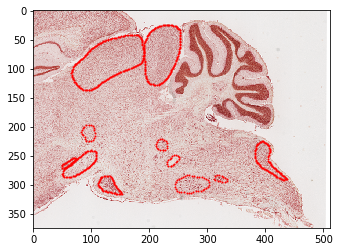

In [62]:
import cv2

img = cv2.imread(img_fn)
plt.imshow( img, cmap='gray' )

plt.scatter(annotations_x, annotations_y, color='r', s=1)

In [33]:
DataManager.get_image_filepath_v2(stack, 100, version="thumbnail", resol=None)

AssertionError: 

### List valid patches according to structures and sections

In [7]:
all_patch_locations = {}

for structure in all_structures:    
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ].tolist()
        all_patch_locations[structure][int(section)] = patch_coors

### Patch examples display

Number of Positive Patches: 159


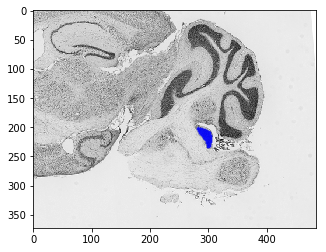

In [9]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
x_offset = 0 #-50
y_offset = 0 #-11
structure = 'DC'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Positive Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

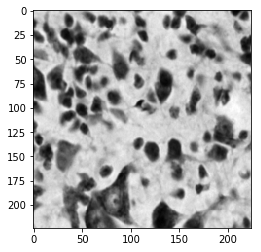

In [10]:

img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 50
x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset*32
y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset*32

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

### Save patches to files

In [ ]:
x_offset = 0 #-1600
y_offset = 0 #-352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


## Negative patches

In [11]:
all_patch_locations = {}

for structure in all_structures: 
    structure=structure+'_surround_200um_noclass'
    valid_sections = []
    try:
        possibly_valid_sections = grid_index_class_lookup[structure].keys()
    except Exception as e:
        print(e)
        print('SKIPPING: '+structure)
        continue
        
    all_patch_locations[structure] = {}

    # Make a list of all sections where patches actually exist
    for section in possibly_valid_sections:
        # If this table entry is a numpy array, then it is filled with data. Otherwise (float) it is 'nan'
        if isinstance(grid_index_class_lookup[structure][section], np.ndarray):
            valid_sections.append( section )
            
    for section in valid_sections:
        valid_patch_indices = grid_index_class_lookup[structure][ section ]
        patch_coors =  all_locs[ valid_patch_indices ].tolist()
        all_patch_locations[structure][int(section)] = patch_coors

Number of Negative Patches: 631


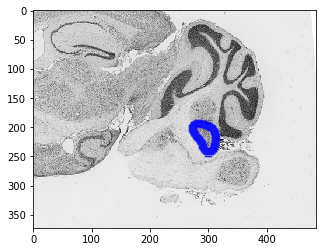

In [12]:
x_pts_str = []
y_pts_str = []
x_raw = []
y_raw = []
# x_offset = -50
# y_offset = -11
structure = 'DC'+'_surround_200um_noclass'
section = all_patch_locations[structure].keys()[20]
valid_patch_indices = grid_index_class_lookup[structure][ section ]
print 'Number of Negative Patches:',len(valid_patch_indices)

for x, y in all_locs[valid_patch_indices]:
    x_raw.append( (float(x)) )
    y_raw.append( (float(y)) )
    x_pts_str.append( (float(x)/32)+x_offset )
    y_pts_str.append( (float(y)/32)+y_offset )
    
img = cv2.imread( images_root+section_to_filename[section]+'_prep2_thumbnail.tif' , 2)
#plt.figure( figsize=(50,50) )
plt.imshow( img, cmap='gray')

plt.scatter(x_pts_str, y_pts_str, s=1, c='blue', alpha=.5)

In [ ]:
img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
index = 20
x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset*32
y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset*32

patch = img[y:y+224,x:x+224]


plt.imshow( patch, cmap='gray')

In [ ]:
# x_offset = -1600
# y_offset = -352
! mkdir $ROOT_DIR/CSHL_patches
! mkdir $ROOT_DIR/CSHL_patches/$stack
for structure in all_patch_locations.keys():
    savepath=ROOT_DIR+'/CSHL_patches/'+stack+'/'+structure
    if os.path.exists(savepath):
        print(structure+' ALREADY EXIST')
        continue
    else:
        ! mkdir $savepath
    for section in all_patch_locations[structure].keys():
        img = cv2.imread( raw_images_root+section_to_filename[section]+'_prep2_lossless_gray.tif', 2)
        for index in range(len(all_patch_locations[structure][section])):
            x = int( float( all_patch_locations[structure][section][index][0] ) ) + x_offset
            y = int( float( all_patch_locations[structure][section][index][1] ) ) + y_offset
            patch = img[y:y+224,x:x+224]
            filename=savepath+'/'+str(section)+'_'+str(index)+'.tif'
            cv2.imwrite(filename, patch)


In [ ]:
%pwd

In [ ]:
%cd $ROOT_DIR/CSHL_patches/$stack

In [ ]:
%ls 

In [ ]:
from glob import glob
for dir in glob('*'):
    print dir